Mandelbrot with 10k zoom levels using dask.delayed and dask.array.
- Lazily define each zoom level as a delayed task
- Stack as a dask.array with chunking
- Preview a few levels and save PNGs
- Optionally write entire stack to Zarr (out-of-core)

Import libraries and prepare an output folder. Zarr is optional.

In [1]:
import numpy as np
import dask
import dask.array as da
from dask import delayed
import matplotlib.pyplot as plt
import stackview

Set parameters: image size, number of levels, zoom, iterations, dtypes and chunking.

In [2]:
HEIGHT = 512
WIDTH = 512
N_LEVELS = 120000#_000
CENTER = (-0.743645857047151, 0.13182592380533)
SCALE0 = 3.0
ZOOM_PER_LEVEL = 1.00025
MAX_ITER = 256
DTYPE = np.uint16
CHUNKS = (1, 256, 256)

Helper to convert iteration counts to uint8 for PNG saving.

In [3]:
def to_uint8(arr, max_val=MAX_ITER):
    a = np.asarray(arr, dtype=np.float32)
    a = np.clip(a, 0, float(max_val))
    a = (255.0 * a / float(max_val)).astype(np.uint8)
    return a

Define a small Mandelbrot renderer returning escape-time counts as a NumPy array.

In [4]:
def mandelbrot_array(height, width, center, scale, max_iter, dtype=np.uint16):
    cx, cy = center
    aspect = width / height
    x = np.linspace(cx - (scale * aspect) / 2.0, cx + (scale * aspect) / 2.0, width, dtype=np.float64)
    y = np.linspace(cy - scale / 2.0, cy + scale / 2.0, height, dtype=np.float64)
    C = x[None, :] + 1j * y[:, None]
    Z = np.zeros_like(C)
    counts = np.zeros(C.shape, dtype=np.int32)
    mask = np.ones(C.shape, dtype=bool)
    for k in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + C[mask]
        escaped = (np.abs(Z) > 2.0) & mask
        counts[escaped] = k
        mask &= ~escaped
        if not mask.any():
            break
    counts[mask] = max_iter
    return counts.astype(dtype, copy=False)

Wrap the renderer in a dask.delayed function and build a lazy 10k-level stack as a dask.array.

In [5]:
@delayed
def render_level(i, height, width, center, scale0, zoom_per_level, max_iter, dtype=np.uint16):
    scale = scale0 / (zoom_per_level ** i)
    return mandelbrot_array(height, width, center, scale, max_iter, dtype)

levels = [
    da.from_delayed(
        render_level(i, HEIGHT, WIDTH, CENTER, SCALE0, ZOOM_PER_LEVEL, MAX_ITER, DTYPE),
        shape=(HEIGHT, WIDTH), dtype=DTYPE
    )
    for i in range(N_LEVELS)
]
stack = da.stack(levels, axis=0).rechunk(CHUNKS)
stack

dask.array<rechunk-merge, shape=(120000, 512, 512), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>

In [6]:

p = stackview.picker(stack, slice_number=3000, colormap="rainbow")
p

In [7]:
image = np.asarray(stack[0:20000:500,::2,::2])
image.shape

(40, 256, 256)

C:\Users\rober\miniforge3\envs\embo25\Lib\site-packages\stackview\_animate.py:43: UserWarning: The timelapse has an intensity range exceeding 0..255. Consider normalizing it to the range between 0 and 255.
  warnings.warn("The timelapse has an intensity range exceeding 0..255. Consider normalizing it to the range between 0 and 255.")



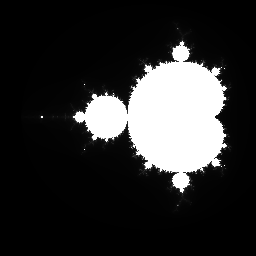

In [8]:
stackview.animate(image)